Copyright © 2021, SAS Institute Inc., Cary, NC, USA.  All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

## Using `Centrality` Actions in the `NETWORK` Actionset to Find the Major Hubs for every Airline

------------------------------------------------------------------------------------------------------------------------------

In this Jupyter notebook, we use the `Centrality` action to find the major hubs of different airlines. Note that the dataset we are using here does not have the number of trips within each flight route. Hence, we are using the unweight parameter when calculating hub centrality.  

Our graph consists of all airports worldwide and the existing air routes between them. We obtain the airlines, airports, and routes, datasets from the "openflights.org" website. The code for reading the data as well as the data preparation and cleaning steps, are stored in the "helper.py" script. 

To read more about the `Centrality` action, refer to [SAS Documentation]( https://pubshelpcenter.unx.sas.com/test/doc/en/pgmsascdc/default/casactml/cas-network-centrality.htm).  
 
------------------------------------------------------------------------------------------------------------------------------
The flow of this notebook is as follows:
* [Reading the airports, airlines, and routes data from openflights website](#1st-bullet)
* [Connecting to CAS server](#2nd-bullet)
* [Uploading links (routes) DataFrame to CAS](#3rd-bullet)
* [Finding major hubs for every airlines](#4th-bullet)
* [Visualizing the major hub of every airline](#5th-bullet)
* [Visualizing the major hub of every airline](#6th-bullet)
* [Visualizing the Delta Airlines major hubs](#7th-bullet)
* [Visualizing the American Airlines major hubs](#8th-bullet)
* [Visualizing the United Airlines major hubs](#9th-bullet)
* [Visualizing the Southwest Airlines  major hubs](#10th-bullet)
------------------------------------------------------------------------------------------------------------------------------
**Prepared by:** Hossein Tohidi (<i class="fa fa-github" aria-hidden="true"></i> [Hossein-Tohidi](https://github.com/Hossein-Tohidi))

In [1]:
import swat
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook  
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()),r"../../common/python"))
import cas_connection as cas 
import geopandas as gpd
from shapely.geometry import Polygon
import helper
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
import time

### Reading the airports, airlines, and routes data from openflights website <a class="anchor" id="1st-bullet"></a>

In [2]:
airports = helper.read_airports("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat")
airports.head()

,AirportID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source,node,pos
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports,GKA,"(145.391998291, -6.081689834590001)"
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports,MAG,"(145.789001465, -5.20707988739)"
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports,HGU,"(144.29600524902344, -5.826789855957031)"
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports,LAE,"(146.725977, -6.569803)"
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports,POM,"(147.22000122070312, -9.44338035583496)"


In [3]:
airlines = helper.read_airlines("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat")
airlines.head()

,Airline ID,Airline Name,Alias,Airline IATA,ICAO,Callsign,Airline Country,Active
1,1,Private flight,\N,-,NaN,NaN,NaN,Y
3,3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
10,10,40-Mile Air,\N,Q5,MLA,MILE-AIR,United States,Y
13,13,Ansett Australia,\N,AN,AAA,ANSETT,Australia,Y
14,14,Abacus International,\N,1B,NaN,NaN,Singapore,Y


In [4]:
routes = helper.read_routes("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",airports,airlines)
routes.head()

,from,Source airport ID,to,Destination airport ID,Codeshare,Equipment,Airline IATA,Airline Name,Airline Country
0,AER,2965,KZN,2990,NaN,CR2,2B,Aerocondor,Portugal
1,ASF,2966,KZN,2990,NaN,CR2,2B,Aerocondor,Portugal
2,ASF,2966,MRV,2962,NaN,CR2,2B,Aerocondor,Portugal
3,CEK,2968,KZN,2990,NaN,CR2,2B,Aerocondor,Portugal
4,CEK,2968,OVB,4078,NaN,CR2,2B,Aerocondor,Portugal


### Connecting to CAS server  <a class="anchor" id="2nd-bullet"></a>

In [5]:
s = cas.reconnect()
s.loadActionSet('network')
s.loadActionSet('optNetwork')

NOTE: Added action set 'network'.
NOTE: Added action set 'optNetwork'.


[actionset]

 'optNetwork'

+ Elapsed: 0.00212s, user: 8.1e-05s, sys: 0.00203s, mem: 0.221mb

### Uploading links (routes) DataFrame to CAS <a class="anchor" id="3rd-bullet"></a>

In [6]:
swat.options.cas.print_messages=False 
s.upload(routes, casout = {'name':'RouteLinks', 'replace':True})
swat.options.cas.print_messages=True 

### Finding major hubs for every airline <a class="anchor" id="4th-bullet"></a>

In [7]:
st = time.time()
s.network.centrality(
    direction = "directed",
    logLevel  = "none",
    links     = {"name":"RouteLinks", "groupBy":"Airline Name"},
    hub       = "unweight",
    outNodes  = {"name":"NodeSetOut", "replace":True})
print(f"Processing centrality used {time.time()-st:.2f} seconds")

Processing centrality used 2.19 seconds


In [8]:
df = s.CASTable('NodeSetOut').to_frame()
df.head()

,Airline Name,node,centr_hub_unwt
0,ABSA - Aerolinhas Brasileiras,AAL,0.57735
1,ABSA - Aerolinhas Brasileiras,OLA,0.57735
2,ABSA - Aerolinhas Brasileiras,OSL,1.00000
3,ABSA - Aerolinhas Brasileiras,VDB,0.57735
4,ALAK,EGN,0.50000


In [9]:
df = df.merge(airports[["node","Latitude","Longitude","Country"]], on='node')
df.sort_values(['Airline Name','centr_hub_unwt'],ascending=False,inplace=True)
df.head()

,Airline Name,node,centr_hub_unwt,Latitude,Longitude,Country
3633,easyJet,LGW,1.000000,51.148102,-0.190278,United Kingdom
1798,easyJet,GVA,0.745025,46.238098,6.108950,Switzerland
4052,easyJet,SXF,0.694351,52.380001,13.522500,Germany
10229,easyJet,BSL,0.645469,47.590000,7.529167,France
3312,easyJet,EDI,0.613001,55.950001,-3.372500,United Kingdom


### Visualizing the major hub of every airline <a class="anchor" id="5th-bullet"></a>

In this section, we are looking for the airport with the highest hub centrality score for different airlines.  

In [10]:
main_hubs_df = df.loc[df.groupby('Airline Name')['centr_hub_unwt'].idxmax()].reset_index(drop=True)
main_hubs_df.head()

,Airline Name,node,centr_hub_unwt,Latitude,Longitude,Country
0,ABSA - Aerolinhas Brasileiras,OSL,1.0,60.121000,11.050200,Norway
1,ALAK,KRT,1.0,15.589500,32.553200,Sudan
2,Abu Dhabi Amiri Flight,YRT,1.0,62.811401,-92.115799,Canada
3,Adria Airways,LJU,1.0,46.223701,14.457600,Slovenia
4,Aegean Airlines,ATH,1.0,37.936401,23.944500,Greece


<IPython.core.display.Javascript object>


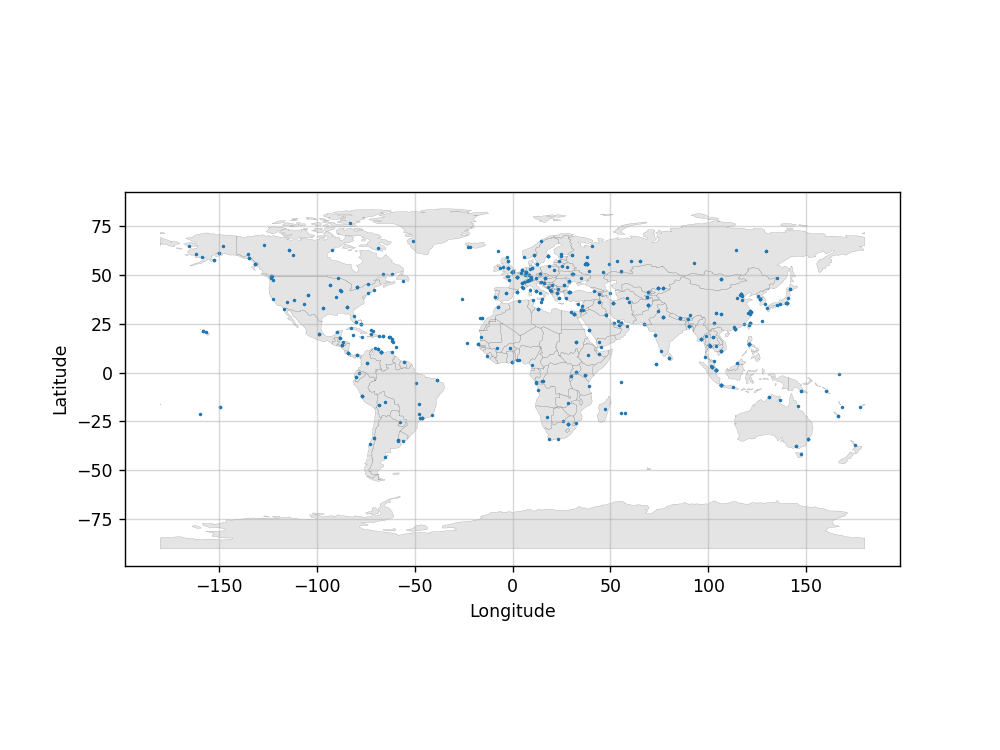

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey",ax=ax, ec="k",lw=0.1, alpha=0.60)
main_hubs_df.plot(x="Longitude",y="Latitude",s=1, kind="scatter", ax=ax)
ax.grid(alpha=0.5)
plt.show()

### Visualizing the main hubs of every airline <a class="anchor" id="6th-bullet"></a>

Here, we find and visualize the airports with the hub centrality score higher than a certain threshold. 

In [12]:
def visualize_hubs(airline,threshold=0.5):
    df_filtered = df.loc[(df['Airline Name']==airline)&(df['centr_hub_unwt']>threshold)]
    df_filtered.sort_values('centr_hub_unwt',inplace=True)
    df_filtered['size'] = (1+np.arange(df_filtered.shape[0]))**2
    fig, ax = plt.subplots(figsize=(8,6))
    mplg = countries.loc[countries['name']=='United States of America','geometry']
    mplg.intersection(Polygon([[-125,20],[-125,50],[-60,50],[-60,20]])).plot(color='lightgrey',ax=ax)
    df_filtered.plot.scatter(x='Longitude',y='Latitude',s='size',ax=ax)
    for row in df_filtered.values:
        plt.text(row[4],row[3]-random.choice([-1,1]),row[1],fontsize=8)
    plt.show()

### Visualizing the Delta Airlines major hubs <a class="anchor" id="7th-bullet"></a>

<IPython.core.display.Javascript object>


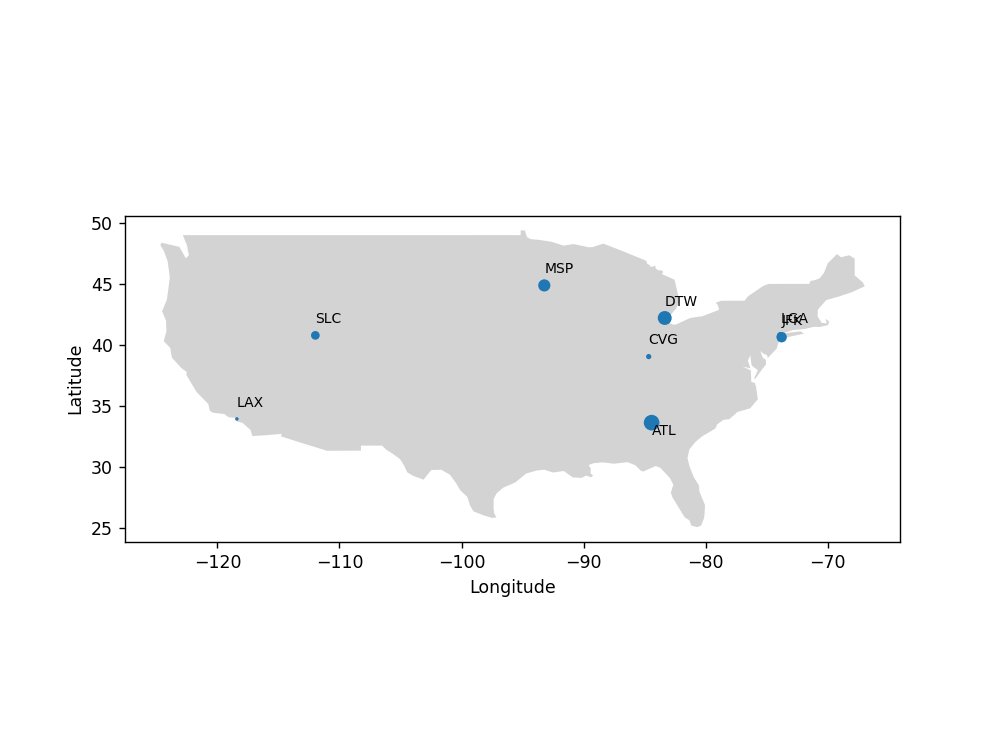

In [13]:
visualize_hubs('Delta Air Lines',threshold=0.45)

### Visualizing the American Airlines major hubs <a class="anchor" id="8th-bullet"></a>

<IPython.core.display.Javascript object>


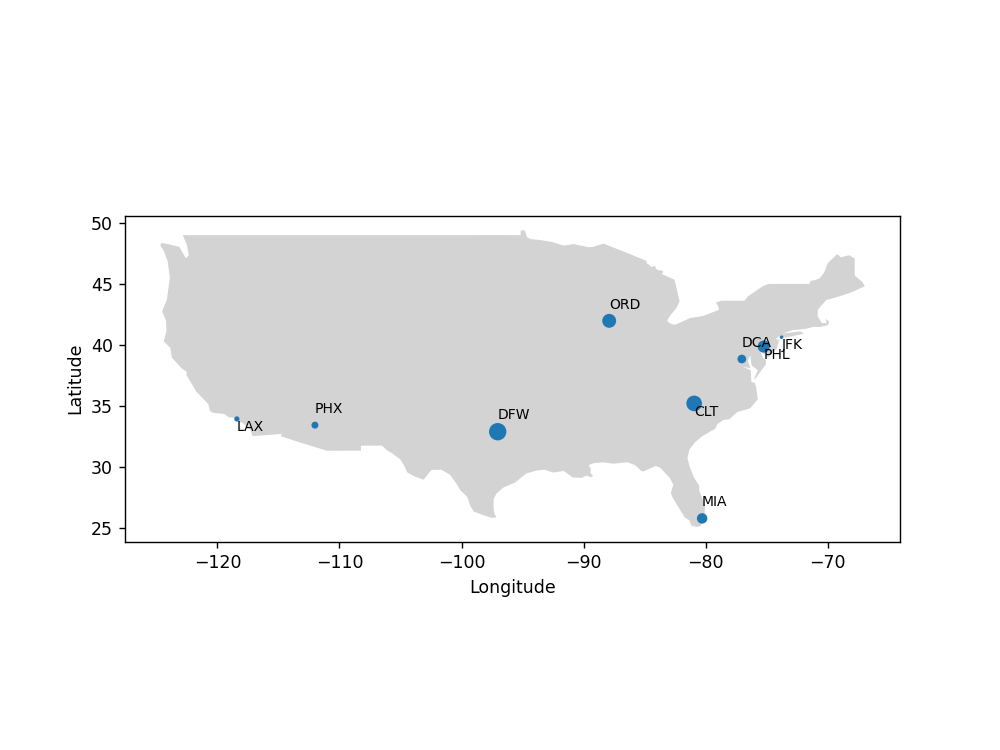

In [14]:
visualize_hubs('American Airlines',threshold=0.5)

### Visualizing the United Airlines major hubs <a class="anchor" id="9th-bullet"></a>

<IPython.core.display.Javascript object>


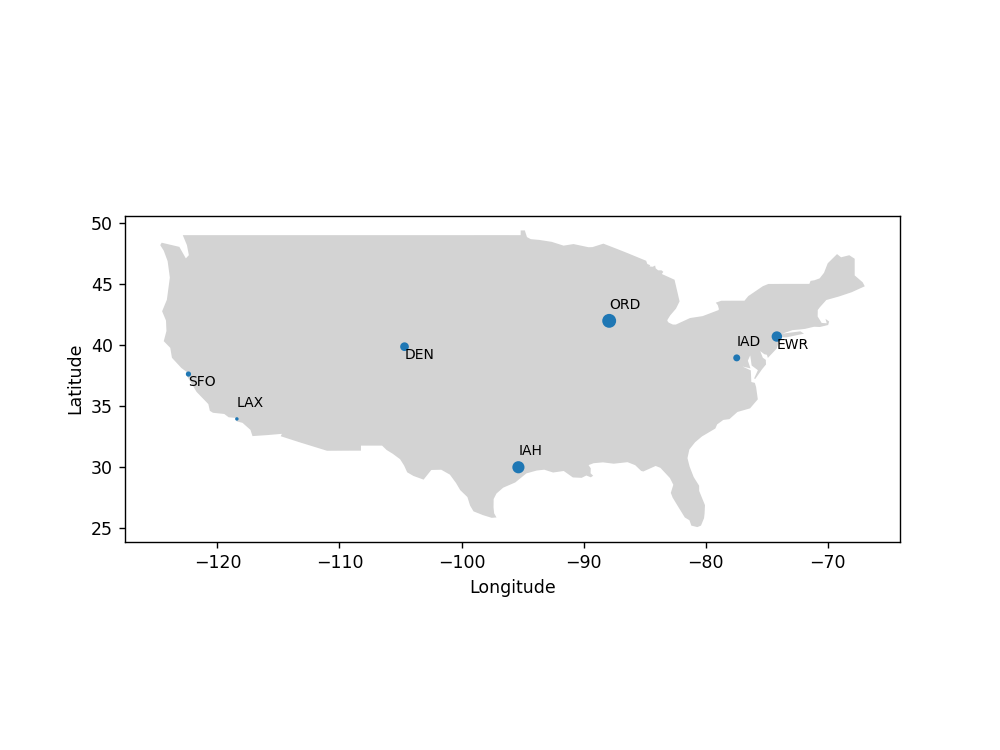

In [15]:
visualize_hubs('United Airlines')

### Visualizing the Southwest Airlines major hubs <a class="anchor" id="10th-bullet"></a>

<IPython.core.display.Javascript object>


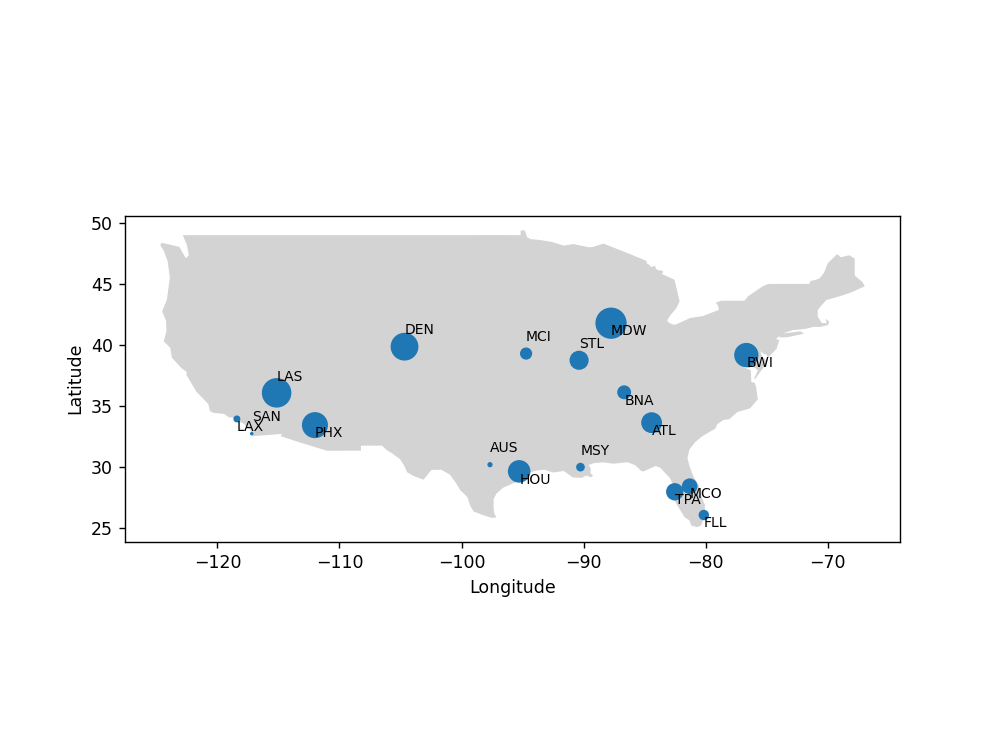

In [16]:
visualize_hubs('Southwest Airlines') 